In [3]:
# Simple dynamic system example: object in 2D space being rotated about the unit circle.
import sys
sys.path.append("..")
from dynamic import *
%matplotlib inline

In [10]:
class Rotation(DynamicSystem):
    '''
    Simple demonstration of setting up and simulating a dynamic system.
    '''
    STATE_SIZE = 2
    INPUT_SIZE = 1
    
    def __init__(self):
        self.state = np.array([1, 0]) #(x, y)
        self.simend = False
        self.H = np.identity(2)
        self.P = np.zeros([2,2])
        self.Q = np.zeros([2,2])
        self.R = np.zeros([2,2])

    def evolve(self, t, dt):
        # B matrix doesn't matter till we add in forces.
        A, B = np.array([[np.cos(dt), -np.sin(dt)], [np.sin(dt), np.cos(dt)]]), np.array([0, 0])
        if self.state[1] < 0 and A.dot(self.state)[1] >= 0:
            self.simend = True
        return A, B

    def ext_input(self, t):
        return 0, None
    
    def reset(self):
        super().reset()

In [11]:
r = Rotation()
time, states, _ = r.simulate(dt=0.01, timeout=30)

Simulation ended at t = 6.28 s due to end condition.


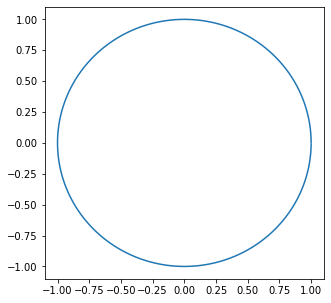

In [12]:
plt.figure(figsize=(5,5))
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.plot(states[0], states[1])

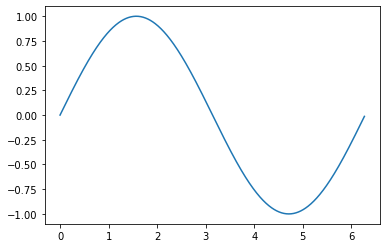

In [13]:
plt.plot(time, states[1])

In [14]:
r.simend

True

In [20]:
class Gravitation(DynamicSystem):
    '''You could make this an N-body simulation if you changed ext_input to read in the positions of N-1 other masses 
    and set the gravitational force input based on those. But this is a more interesting control example, and simpler.
    This is dependent on the approximation m_orbiting << m_center, which is valid for something like a satellite 
    orbiting Earth, but if you have them closer together or if you set the timestep too high you may see the orbit
    spiral. (We'll use this as the control example in a minute!)
    '''

    STATE_SIZE = 4
    INPUT_SIZE = 2
    
    def __init__(self, m_center, m_orbiting, radius, G=6.67e-11):
        #possible to override G only for testing purposes.
        self.G = G
        self.state = np.array([radius, 0, 0, np.sqrt(G*(m_center + m_orbiting)/radius)]) #(x, dx/dt, y, dy/dt)
        self.simend = False
        self.H = np.identity(self.STATE_SIZE)
        self.P = np.zeros([self.STATE_SIZE,self.STATE_SIZE])
        self.Q = np.zeros([self.STATE_SIZE,self.STATE_SIZE])
        self.R = np.zeros([self.STATE_SIZE,self.STATE_SIZE])
        self.m_orbiting = m_orbiting
        self.m_center = m_center

    def evolve(self, t, dt):
        A = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
        B = np.array([[dt**2/(2*self.m_orbiting), 0], 
                      [dt/self.m_orbiting, 0], 
                      [0, dt**2/(2*self.m_orbiting)], 
                      [0, dt/self.m_orbiting]])
        return A, B

    def ext_input(self, t):
        r = np.sqrt((self.state[0]**2 + self.state[2]**2))
        return -(self.G*self.m_center*self.m_orbiting/r**3)*np.array([self.state[0], self.state[2]]), None
    
    def reset(self):
        super().reset()

In [21]:
g = Gravitation(1000, 1, 1, 1)
time, states, inputs = g.simulate(dt=1e-6, timeout=1)
# can terminate this cell early.

Simulation ended at t = 1.0 s due to timeout.


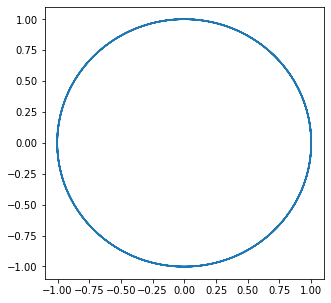

In [22]:
plt.figure(figsize=(5,5))
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.plot(states[0], states[2])

In [23]:
# now consider the ISS orbiting the Earth
ISS = Gravitation(5.972e+24, 4e+5, 6779000)
time, states, inputs = ISS.simulate(dt=1, timeout=365*24*60*60)


Steps completed: 15968377
Simulation ended at t = 15968377 s due to interrupt.


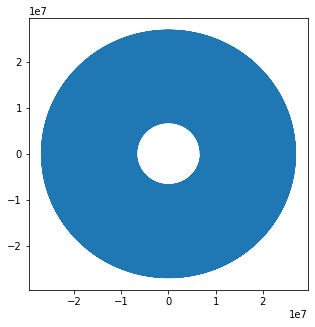

In [24]:
plt.figure(figsize=(5,5))
plt.plot(states[0], states[2])

In [79]:
# Now suppose you launched a satellite but it doesn't have sufficient starting velocity. What happens?
satellite = Gravitation(5.972e+24, 4e+5, 6779000)
satellite.state[3] /= 2
time, states, inputs = satellite.simulate(dt=1, timeout=24*60*60)

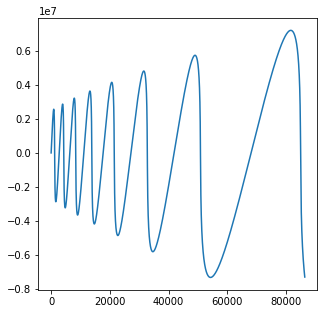

In [82]:
plt.figure(figsize=(5,5))
plt.plot(time, states[2])